<a href="https://colab.research.google.com/github/juandmantilla/Prediccion-LQI-RSSI-series-de-tiempo/blob/master/LSTM_mas_pasos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM para más predicciones

En este notebook se tratará de automatizar los procesos para la evaluación de LSTM para mas de una predicción en el futuro.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- Carga de Modelos ----------------------
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA
from sklearn.svm import SVR
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# ----------------------------------------------------------------------

# Función que retorna un dataframe según las condiciones de nodeId y SrcNode
def cargarDatos(direccion, nodeId, SrcNode):
    nodos = pd.read_csv(direccion)
    nodos = nodos.loc[nodos['NodeId'] == nodeId]
    nodos = nodos.loc[nodos['SrcNodeId'] == SrcNode ]

    #Devuelve un dataframe
    return nodos

# Función que realiza la diferencia entre una observación en el tiempo t con respecto a
# otra en el tiempo t-1. Los valores que corresponden a cero serán cambiados a 0.5 para
# evitar posibles indeterminaciones en el cálculo de erroes.
def diferenciarSerie(datos, indicador):
    a = datos[[indicador]].diff(periods = 1).values
    a[0] = a[1]
    fecha = datos[["Date"]].values
    
    b = np.concatenate((fecha, a), axis = 1)
    
    datos = pd.DataFrame(data = b, columns=["Date", indicador])
    
    #Cambio de valores con 0 para evitar indeterminaciones
    datos.loc[datos[indicador] == 0, indicador] = 0.5
    return datos
  

# Función que genera una serie de tiempo de promedios móviles. La ventana móvil
# indicada es de 5 observaciones temporales.
def promediarSerie(datos, indicador):
    datos = datos.rolling(15).mean()
    datos[indicador].fillna(0.5, inplace = True)
    return datos
    
# Función que genera 2 subconjuntos de datos. 
# * dataX corresponde a las observaciones X_t = Y_t-1
# * dataY corresponde a las observaciones en el tiempo t
def unPaso(datos, indicador):    
    dataX = np.array([])
    dataY = np.array([])
    
    for i in range(len(datos.values)):
        dataX = np.append(dataX, datos[[indicador]].values[i-1])
        dataY = np.append(dataY, datos[[indicador]].values[i])
    
    dataX[0] = 0
    
    return dataX, dataY

# Función que genera 2 subconjuntos de datos.
# * dataTransform[:, :-1] es una arreglo bidimensional que contiene los  t-n observaciones anteriores a t.
# * dataTransform[:, -1] es un arreglo unidimensional que contiene las observaciones en un tiempo t.
# Este algoritmo es basado en el recurso en línea: 
# https://stackoverflow.com/questions/48967169/time-delay-embedding-of-time-series-in-python
def multiplesPasosLSTM(datos, indicador, pasos):
    a = np.array([])
    for i in datos[[indicador]].values:
        a = np.append(a, i[0])
  
      # Se implementa el Time Delay Embedding. Que es una ténica para obtener los valores t - n hacia atrás de un
      # valor LQI en el tiempo t. Esta función recibe el parámetro w que indica la cantidad de pasos hacia atrás que se
      #tendrán en cuenta y el parámetro g define la cantidad de pasos para una observación en un tiempo t + g


    w = pasos*2  #----> Cantidad de observaciones que se tienen en cuenta para definir la observación en tiempo t más uno

    g = 1  # ---> Si una observación está en el tiempo t, esta define la siguiente observación en tiempo t + g

    dataTransform = a[(np.arange(w)*(g))+ np.arange(np.max(a.shape[0] - (w-1)*(g), 0)).reshape(-1,1)]
    dataTransform = np.array(dataTransform)
    
        
    return dataTransform[:, :-pasos], dataTransform[:, -pasos:]


#---------------------------------------------DEFINICIÓN DE MODELOS ------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------


# Función para arreglos unidimensionales. Función para transformar el dominio
# de los datos. Retorna datos escalados con su respectivo escalador (scaler).
# Este algoritmo es basado en el recurso en línea: 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
def cambiarEscala_LSTM(dataX, dataY):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(dataX)

  dataX = scaler.transform(dataX)
  dataY = scaler.transform(dataY)

  return dataX, dataY, scaler

# Función de inversión de escala de datos, retorna datos en el dominio original 
def invertirEscala(scaler, datos):
    datos = scaler.inverse_transform(datos)
    return datos


def prediccionLSTM(modelo, batch_size, x_test, pasos):
  if (pasos == 1):
    x_test = x_test.reshape((1, 1, x_test.shape[0]))
    pred = modelo.predict(x_test, batch_size = batch_size)

  elif (pasos > 1):
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    pred = modelo.predict(x_test, batch_size = batch_size)
    
  return pred

# -------------------------------------- MODELO LSTM  ----------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------


# Función modeloLSTM realiza pretratamiento de datos y genera; conjuntos de entrenamiento y prueba,
# modelo de red LSTM, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de entrenamiento, prueba y regresiones (renombrado como predicciones).
def modeloLSTM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador,
              numNeuronas, batch_size, numEpoc):
  fc = 0
  pred = np.array([])
  y_test = np.array([])
  y_train = np.array([])

  # Pasos sin diferenciar ----------------------------------------------------------------------------
  if ((pasos > 1) and diferenciada == False):
    dataX, dataY, scaler = cambiarEscala_LSTM(dataX, dataY)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    x = int(numNeuronas/2)
    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, dropout = 0.2, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(x))
    model.add(Dense(pasos))
    model.compile(loss='mean_squared_error', optimizer='adam')

    

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos. Están en la misma escala 
    y_train = invertirEscala(scaler, y_train)
    pred = invertirEscala(scaler, testPredict)
    y_test = invertirEscala(scaler, y_test)

  # Pasos y diferenciada --------------------------------------------------------------------
  elif((pasos > 1) and diferenciada == True):

    dataX, dataY, scaler  = cambiarEscala_LSTM(dataX, dataY)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

    fc = x_train.shape[0] + x_train.shape[1] 

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    x = int(numNeuronas/2)
    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, dropout = 0.2, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(x))
    model.add(Dense(pasos))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    trainPredict = invertirEscala(scaler, trainPredict)
    y_train = invertirEscala(scaler, y_train)

    pred = invertirEscala(scaler, testPredict)
    y_test = invertirEscala(scaler, y_test)
    
    a = np.array([])
    b = np.array([])

    #Operación inversa para retornar los valores a su dominio real.

    fc1 = fc
    for i in range(len(pred)):

      for j in range(0, pasos):
        a = pred[i][j] + datosOriginales[indicador].values[fc1 + j]
        b = np.append(b, a)

      fc1 = fc1 + 1
    # Transformación de datos a su matriz original
    pred = np.reshape(b, (-1, pasos))
    
    y_train = datosOriginales[indicador].values[ : fc ]
    y_test = datosOriginales[indicador].values[fc :  ]
    
    y_train = y_train[(np.arange(pasos)*(1))+ np.arange(np.max(y_train.shape[0] - (pasos-1)*(1), 0)).reshape(-1,1)]
    y_test = y_test[(np.arange(pasos)*(1))+ np.arange(np.max(y_test.shape[0] - (pasos-1)*(1), 0)).reshape(-1,1)]

    pred = pred[:y_test.shape[0]]

  return y_test, pred, y_train

#---------------------------------------ERRORES---------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------


# Función errores retorna los diferentes métricas de error con respecto
# a los datos de prueba y las predicciones. Para el cálculo de estos errores se debe considera
# que existen múltiples entradas y múltiples predicciones que genera LSTM. Para cada una de 
# las filas en la matriz de datos de prueba el modelo LSTM genera predicciones de igual dimensión
# que la matriz de datos de prueba. A partir de las filas de datos de prueba y las predicciones se
# halla el error entre esas 2 filas, generando un único valor de error para esa fila.
def errores_LSTM(y_test, pred):
  
  MSE = np.array([])
  MAPE = np.array([])
  MAE = np.array([])
  r2 = np.array([])

  if (y_test.shape[0] == pred.shape[0]):
    for i in range(len(y_test)):
      MSE = np.append( MSE, (round(mean_squared_error( y_test[i] , pred[i]), 4)))
      MAPE = np.append(  MAPE, round( np.mean(np.abs((y_test[i] - pred[i]) / y_test[i])) * 100, 4) )
      MAE = np.append(MAE, round( median_absolute_error(y_test[i], pred[i]), 4))
      r2 = np.append( r2, round(r2_score(y_test[i], pred[i]), 4))

    MSE = round(np.mean(MSE), 4)
    MAPE = round(np.mean(MAPE), 4)
    MAE = round(np.mean(MAE), 4)
    r2 = round(np.mean(r2), 4)
  else:
    print("Tamaños incompatibles y_test y pred")
    print("y_test : ", y_test.shape)
    print("pred : ", pred.shape)

  return MSE, MAPE, MAE, r2
  

#-----------------------------------------MOSTRAR SERIE-------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------

#Asignación de variables para guardar las predicciones de los pasos 2 y 3.
pred2 = np.array([])
pred3 = np.array([])

A = 0
a = np.array([])
b = np.array([])
c = np.array([])
d = np.array([])
def mostrarSerie(datosOriginales,  y_train, pred, indicador, modelo, pasos, diferencia):
  global pred2, pred3, A, a, b, c, d 

  A = y_train.shape[0]
  a = np.append(a, datosOriginales[["Date"]].values[A])
  b = np.append(b, datosOriginales[["Date"]].values[A + 1])
  c = np.append(c, datosOriginales[["Date"]].values[A + 2])
  d = np.append(d, datosOriginales[["Date"]].values[A + 3])
  
  
  if (pasos == 2):
    pred2 = pred
    plt.plot([a[0], b[0]], [pred[0][0], pred[0][1]], label = "2 timesteps", marker = '*')
    
  elif (pasos == 3):
    pred3 = pred
    plt.plot([a[0], b[0]], [pred2[0][0], pred2[0][1]], label = "2 timesteps", marker = '*')
    plt.plot([a[1], b[1], c[1]], [pred[0][0], pred[0][1], pred[0][2]], label= "3 timesteps", marker="X")
    
  elif (pasos == 4):
    plt.plot([a[0], b[0]], [pred2[0][0], pred2[0][1]], label = "2 timesteps", marker = '*')
    plt.plot([a[1], b[1], c[1]], [pred3[0][0], pred3[0][1], pred3[0][2]], label= "3 timesteps", marker="X")
    plt.plot([a[2], b[2], c[2], d[2]], [pred[0][0], pred[0][1], pred[0][2], pred[0][3]], label = "4 timesteps", marker = "D" )


# Función que limpia las variables usadas para la visualización de las predicciones.
def limpiarVariables():
  global pred2, pred3, A, a, b, c, d 
  pred2 = np.array([])
  pred3 = np.array([])
  A = np.array([])
  a = np.array([])
  b = np.array([])
  c = np.array([])
  d = np.array([])


    
def labelSerie(datosOriginales, indicador, pasos, y_train):
  #Imprimir serie temporal real
  plt.plot(datosOriginales[["Date"]][y_train.shape[0] - 10 : y_train.shape[0] + 10],
           datosOriginales[[indicador]].values[y_train.shape[0] - 10 : y_train.shape[0] + 10], color="black", label = "Original")
  plt.legend()

  #Título y subtítulo del gráfico
  plt.title("Node " + str(nodeId) + " - " + str(SrcNode) )
  plt.suptitle("Timestep : " + str(pasos))
    

def cajasBigotes( LSTM):
  LSTM = np.array(LSTM).ravel()
  plt.boxplot((LSTM), sym="o", labels=["LSTM"])


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **FUNCIÓN EJECUTAR MODELOS**

In [ ]:
#Parámetro diferencia hace referencia a un booleano para indicar si la serie que se usa es diferenciada
# dataX, dataY, pasos, diferenciada, datosOriginales, indicador

def ejecutarModelos(diferencia, promediada, path, nodeId, SrcNode, indicador, numNeuronas, epocas ):
    
  #Guarda en variable los datos cargados. Evitar cargar varias veces.
  datos = cargarDatos(path, nodeId, SrcNode)
    
    
  #Diccionarios que guardan los errores de los modelos
  dicLSTM = {}

    
  if (diferencia == False and promediada == False ):
    print ("----------------------- SIN DIFERENCIAS ---------------------")
        
    for i in range(1,5):
      if (i>1):
        #Ejecutar modelos para más pasos históricos
        #datosML = multiplesPasos(datos, indicador, i)    #----> Sólo para RF Y SVM
        datosML_LSTM = multiplesPasosLSTM(datos, indicador, i)

        plt.figure(figsize=(15, 5))
                
        m_LSTM = modeloLSTM(datosML_LSTM[0], datosML_LSTM[1], i, False, datos, indicador, numNeuronas, 1, epocas) 
        mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
        labelSerie(datos, indicador, i, m_LSTM[2])

        #Cajas y bigotes
        plt.figure(figsize=(15, 5))
        cajasBigotes(m_LSTM[1])
                
        #Errores
        errorLSTM  = errores_LSTM( m_LSTM[0], m_LSTM[1]) 
        #Guarda en diccionario
        dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM
        
    return dicLSTM
  elif (diferencia == True and promediada == False):
    print("-----------------------  SERIE DE DIFERENCIAS -----------------")
      
    for i in range(1,5):
      if (i>1):
        datosML = diferenciarSerie(datos, indicador)
        datosML_LSTM = multiplesPasosLSTM(datosML, indicador, i)

        plt.figure(figsize=(15, 5))
                                        
        m_LSTM = modeloLSTM(datosML_LSTM[0], datosML_LSTM[1], i, True, datos, indicador, numNeuronas, 1, epocas)
        mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
        
        labelSerie(datos, indicador, i, m_LSTM[2])

        #Cajas y bigotes
        plt.figure(figsize=(15, 5))
        cajasBigotes(m_LSTM[1])

        #Errores
        errorLSTM  = errores_LSTM( m_LSTM[0], m_LSTM[1])

        #Guarda en diccionario
        dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

    return dicLSTM
        
  elif (diferencia == True and promediada == True):
        
    print ("---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------")
        
    for i in range(1,5):
      if (i>1):
        datosML = diferenciarSerie(datos, indicador)
        datosML = promediarSerie (datosML, indicador)
        datosML_LSTM = multiplesPasosLSTM(datosML, indicador, i)

        plt.figure(figsize=(15, 5))
                           
        m_LSTM = modeloLSTM(datosML_LSTM[0], datosML_LSTM[1], i, True, datos, indicador, numNeuronas, 1, epocas)
        mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
        
        labelSerie(datos, indicador, i, m_LSTM[2])

        #Cajas y bigotes
        plt.figure(figsize=(15, 5))
        cajasBigotes(m_LSTM[1])

        #Errores
        errorLSTM  = errores_LSTM( m_LSTM[0], m_LSTM[1])

        #Guarda en diccionario
        dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

        
    return dicLSTM


# **EJECUCIÓN MODELOS**






# **Distribución Original**

**Valores LQI**


----------------------- SIN DIFERENCIAS ---------------------


{'Errores modelo LSTM : 2': (21.0719, 53.3463, 4.3523, -11.9201),
 'Errores modelo LSTM : 3': (7.3104, 28.832, 2.426, -5.1354),
 'Errores modelo LSTM : 4': (3.2359, 18.1382, 1.3832, -7.123762521535326e+29)}

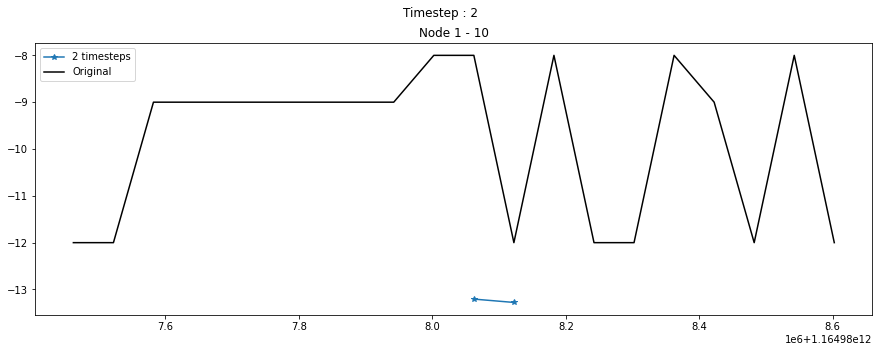

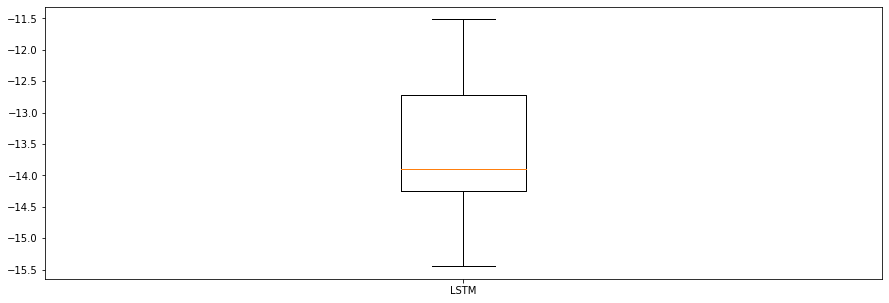

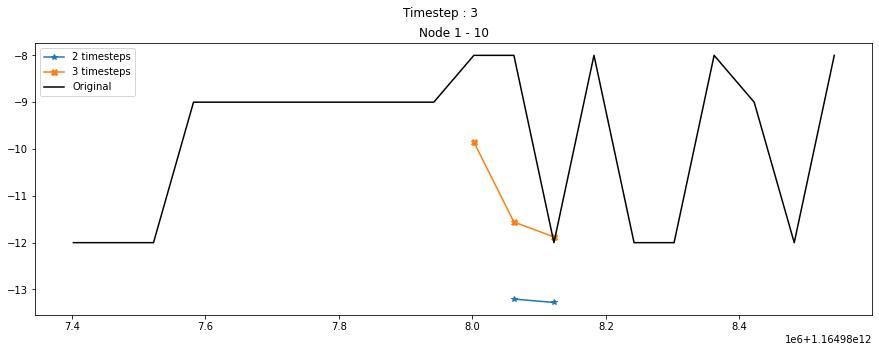

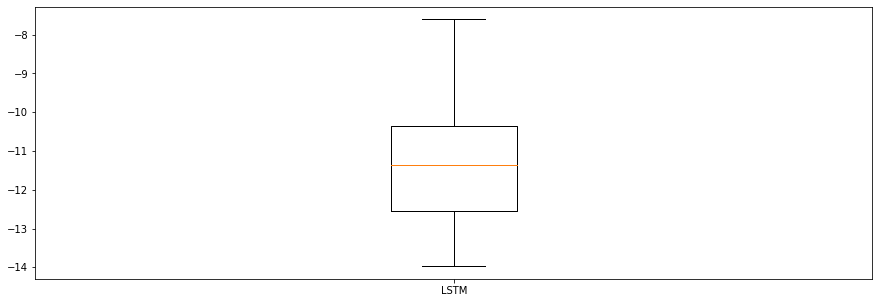

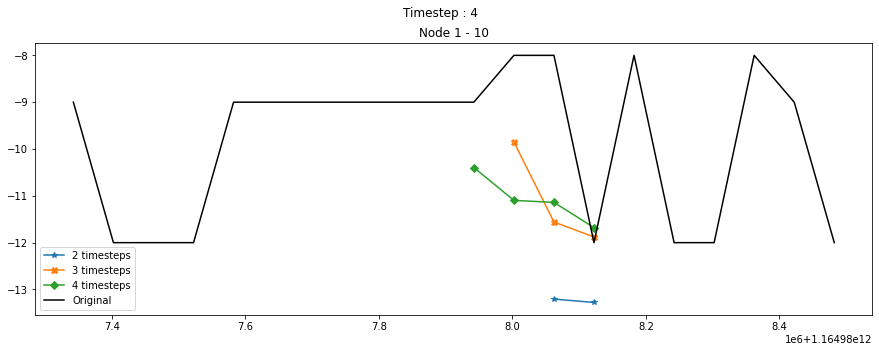

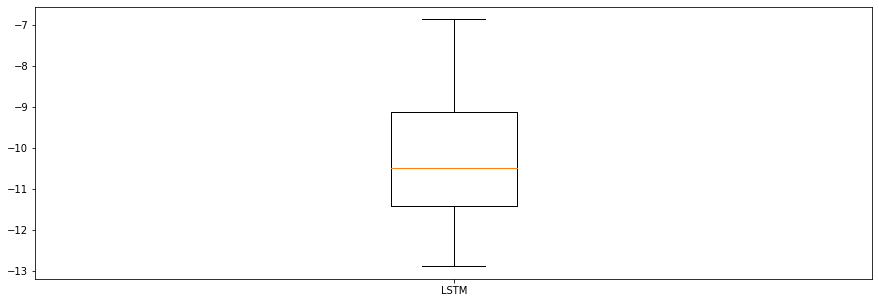

In [ ]:
# --> Entrada modelos RF, SVM   dataX, dataY, pasos, diferenciada, datosOriginales, indicador

# --> Entrada ejecutarModelos  diferencia, promediada, path, nodeId, SrcNode, indicador 

#Variables de entrada
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataAritmetica.csv"
nodeId = 1
SrcNode = 2
indicador = "LqiValue"
numNeuronas = 64
epocas = 16
    

ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

-----------------------  SERIE DE DIFERENCIAS -----------------


{'Errores modelo LSTM : 2': (0.2737, 5.1409, 0.4473, 0.2236),
 'Errores modelo LSTM : 3': (0.1343, 3.2084, 0.2003, 0.4253),
 'Errores modelo LSTM : 4': (0.4126, 7.2398, 0.6247, 0.2543)}

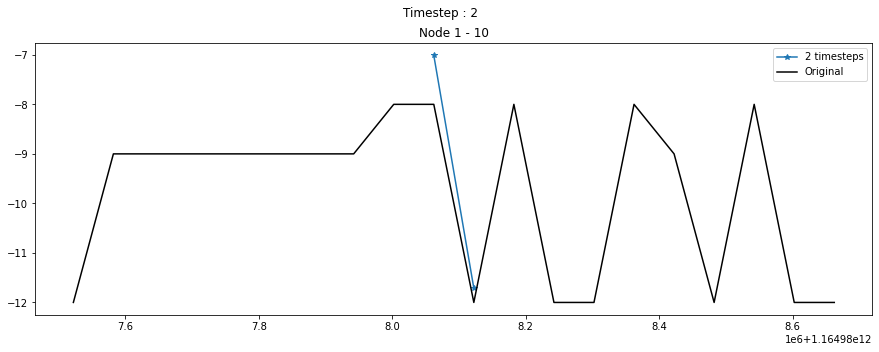

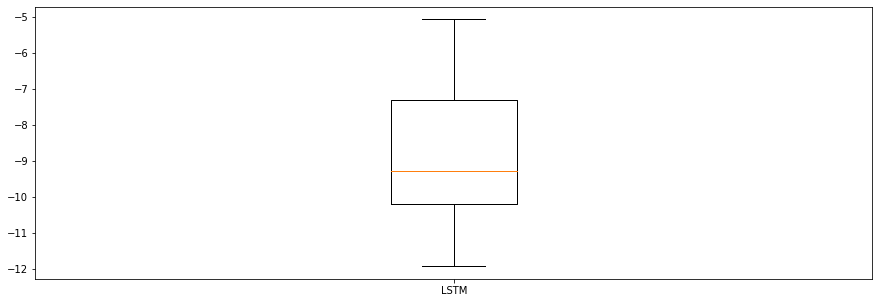

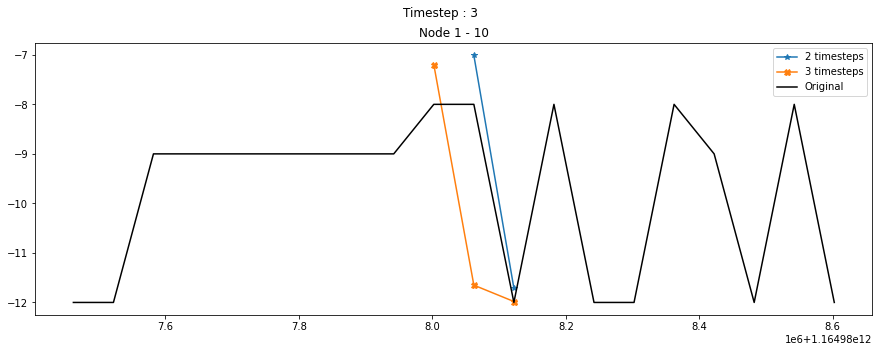

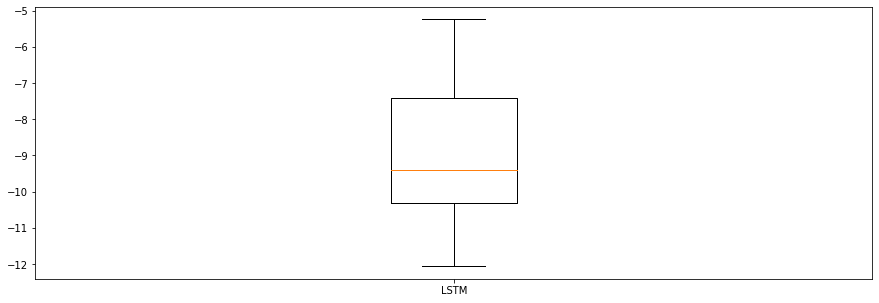

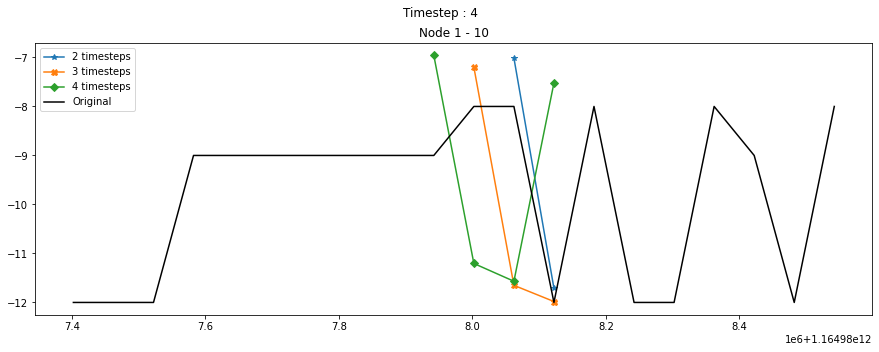

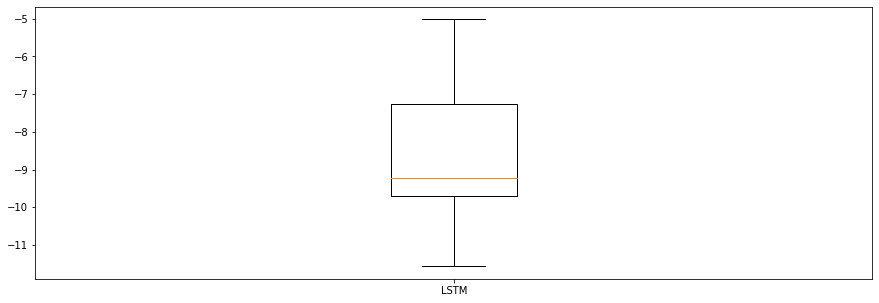

In [ ]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


{'Errores modelo LSTM : 2': (0.1477, 4.338, 0.3786, 0.2805),
 'Errores modelo LSTM : 3': (0.1642, 4.5607, 0.3921, 0.3958),
 'Errores modelo LSTM : 4': (0.1414, 4.2204, 0.365, 0.5012)}

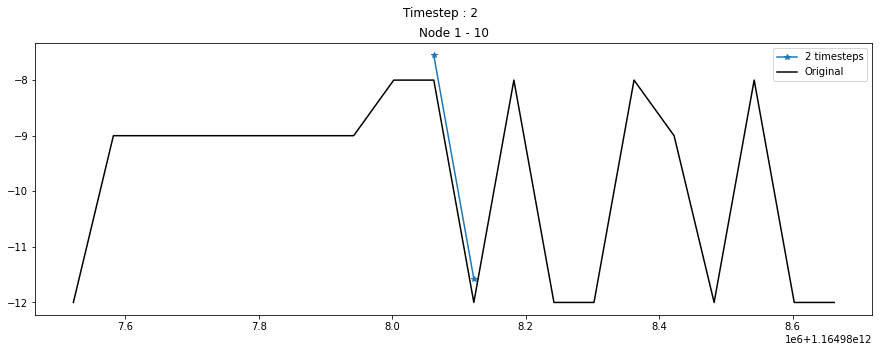

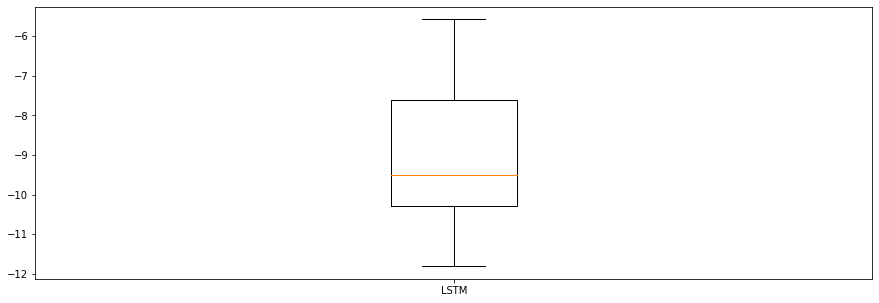

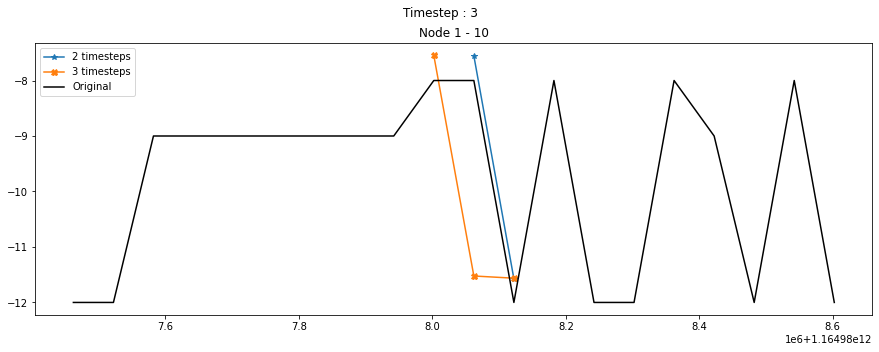

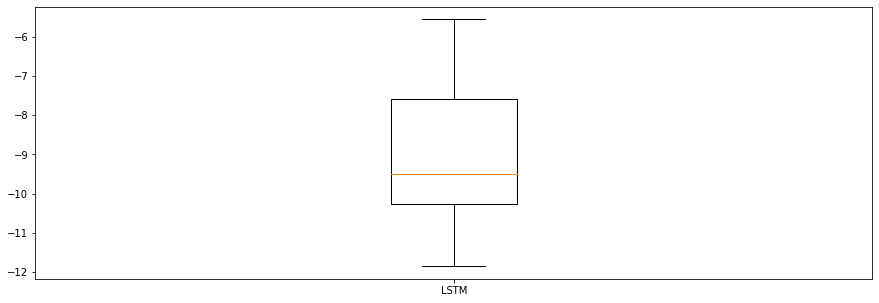

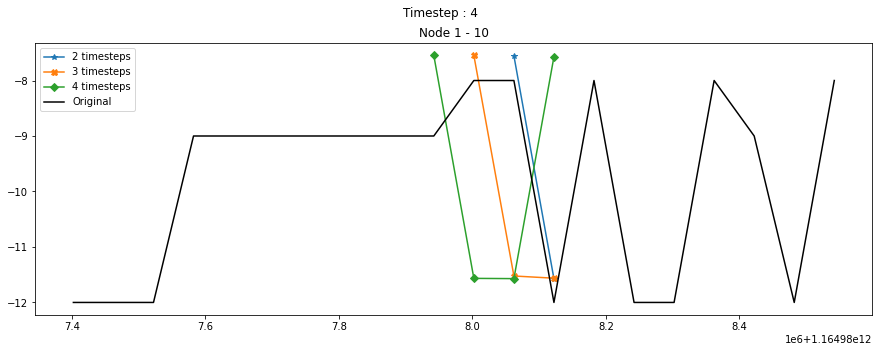

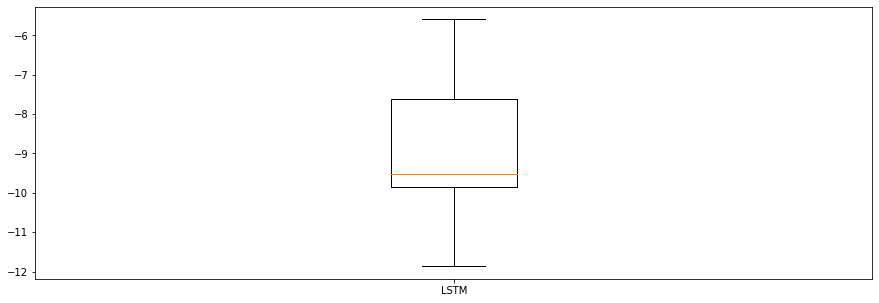

In [ ]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

# **Distribución arimética**

* Datos en orden par son multiplicados por un factor 0.02
* Datos en orden impar son multiplicados por un factor 0.03
* Datos en orden múltiplo de 5 son multiplicados por un factor 0.05

----------------------- SIN DIFERENCIAS ---------------------


{'Errores modelo LSTM : 2': (39.9847, 73.8224, 6.1217, -37.7001),
 'Errores modelo LSTM : 3': (4.0394, 21.0338, 1.5943, -3.1756),
 'Errores modelo LSTM : 4': (16.6013, 46.2865, 3.7219, -1.851251018833864e+30)}

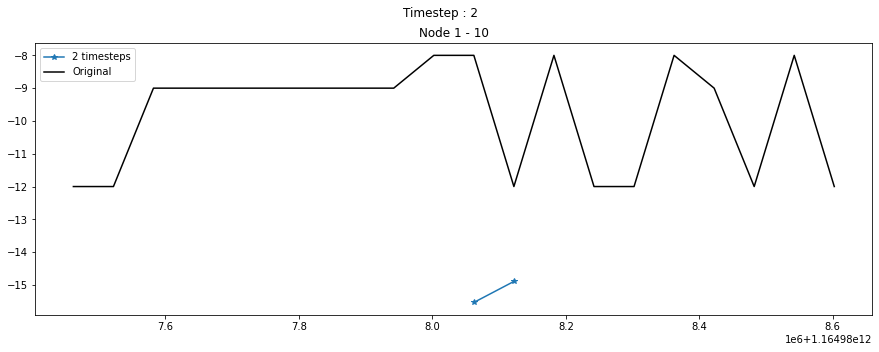

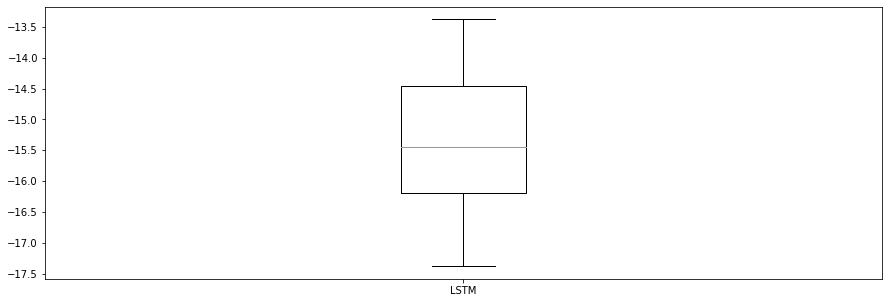

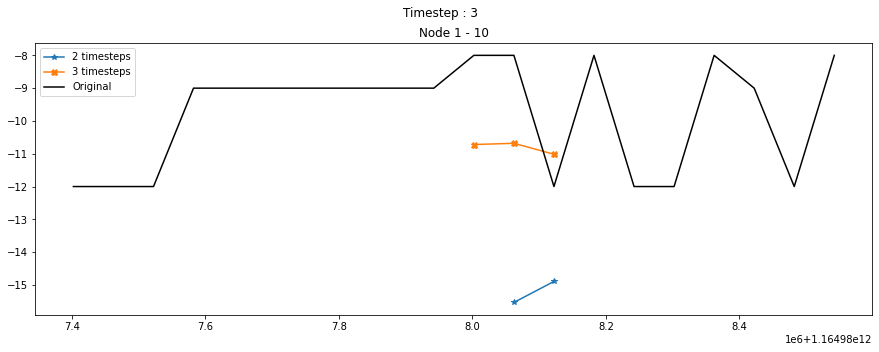

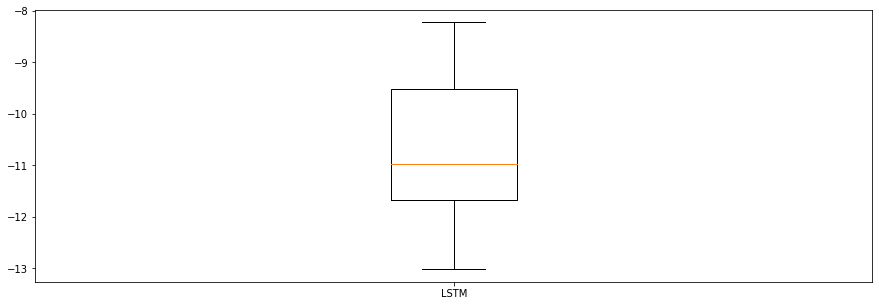

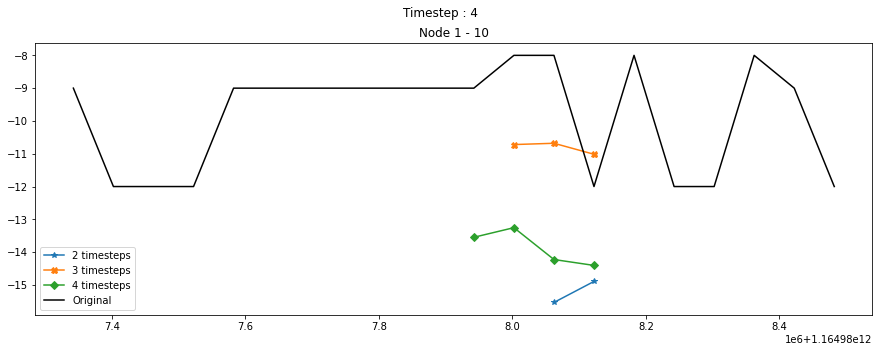

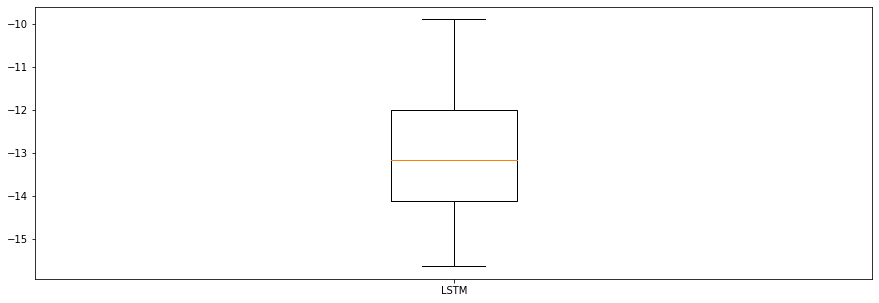

In [ ]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataAritmetica.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 256
epocas = 16
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

-----------------------  SERIE DE DIFERENCIAS -----------------


{'Errores modelo LSTM : 2': (0.2006, 4.0563, 0.3558, 0.2968),
 'Errores modelo LSTM : 3': (0.1459, 4.0053, 0.4253, 0.5023),
 'Errores modelo LSTM : 4': (0.1954, 4.5171, 0.3434, 0.4923)}

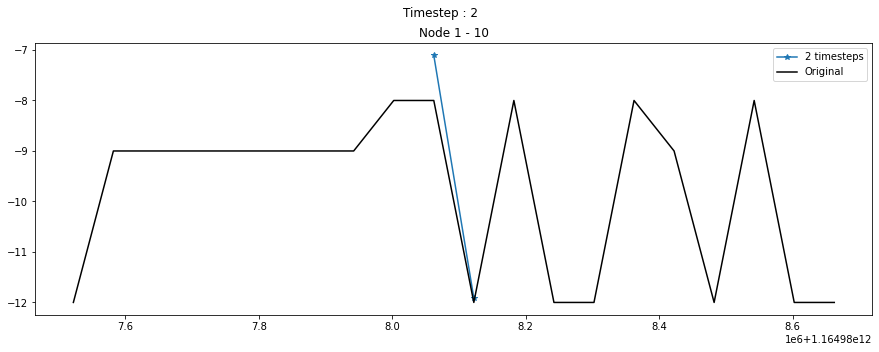

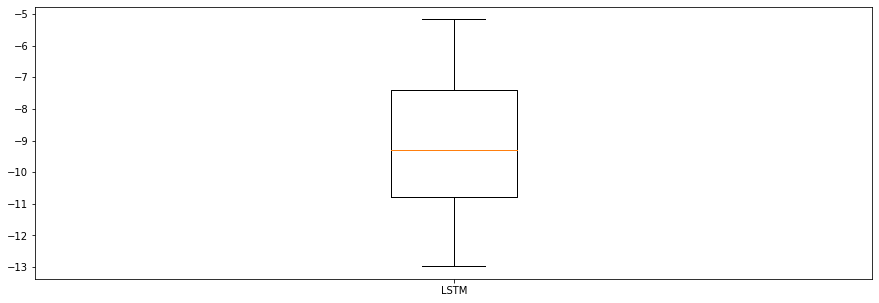

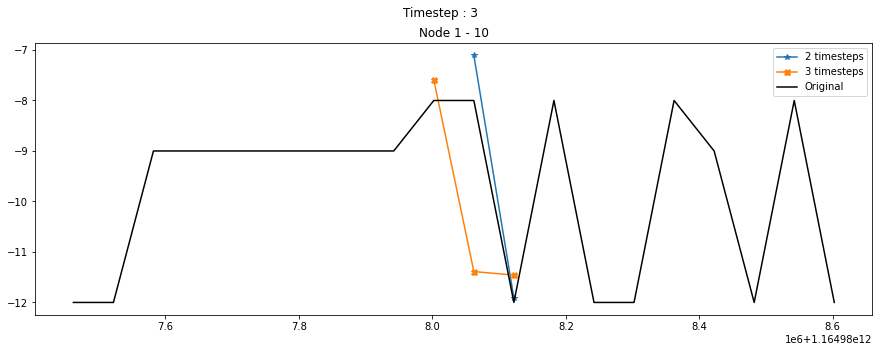

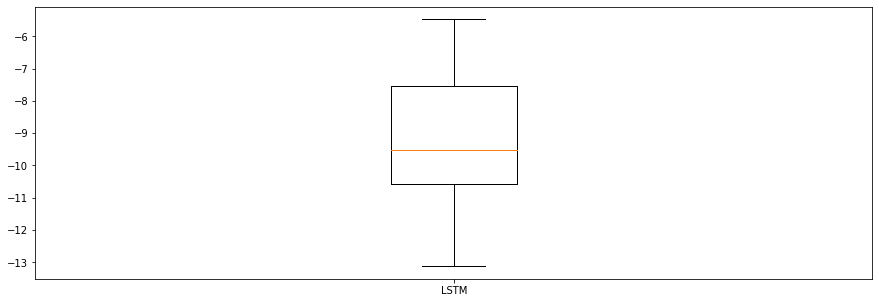

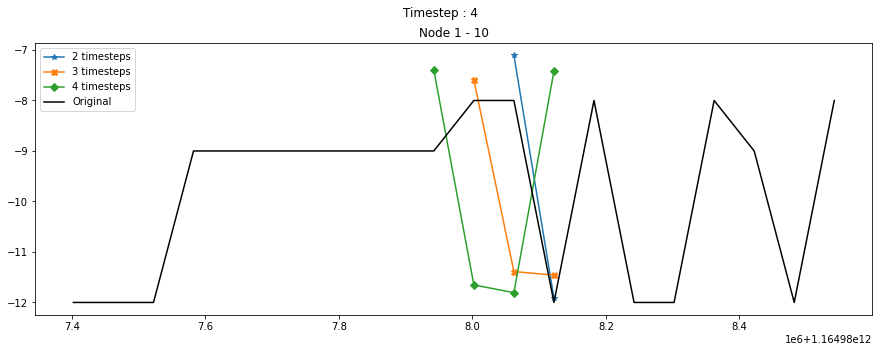

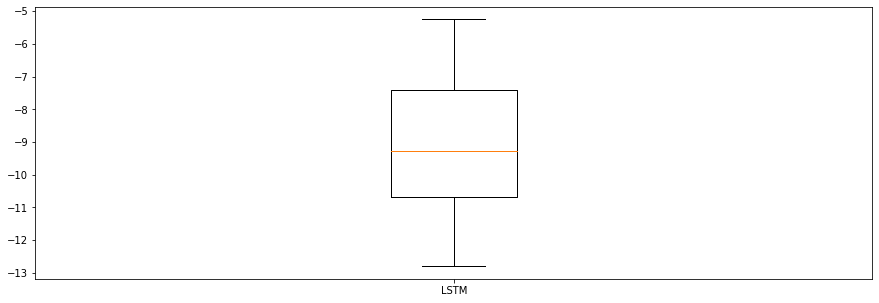

In [ ]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


{'Errores modelo LSTM : 2': (0.0834, 3.261, 0.2833, 0.4235),
 'Errores modelo LSTM : 3': (0.0822, 3.2313, 0.2694, 0.5882),
 'Errores modelo LSTM : 4': (0.0791, 3.1819, 0.2786, 0.7102)}

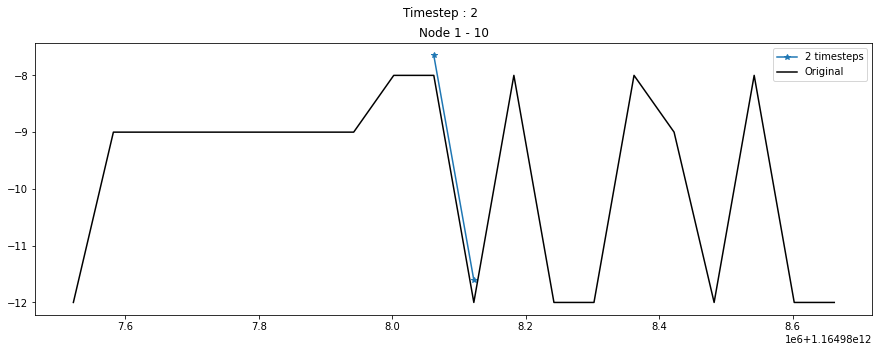

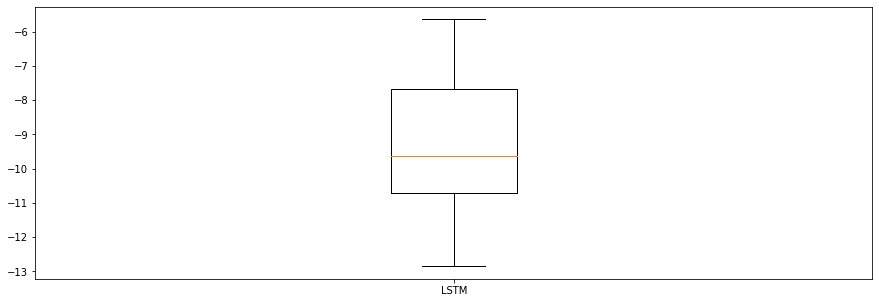

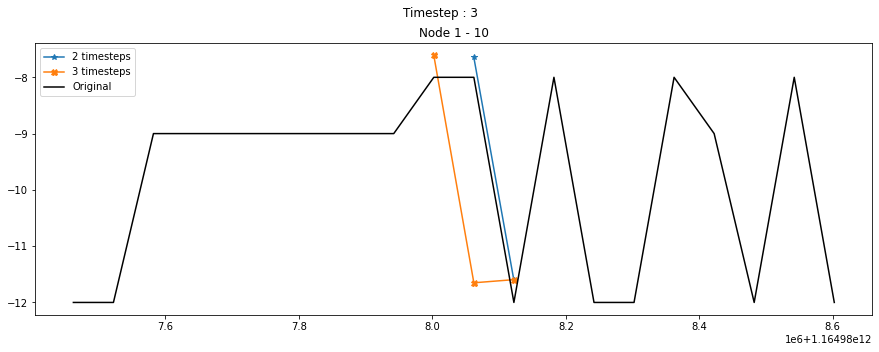

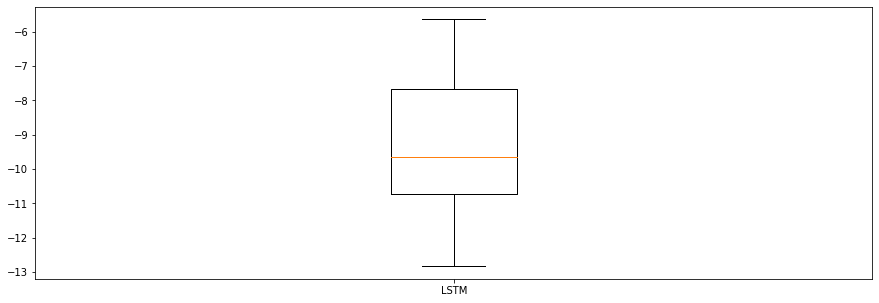

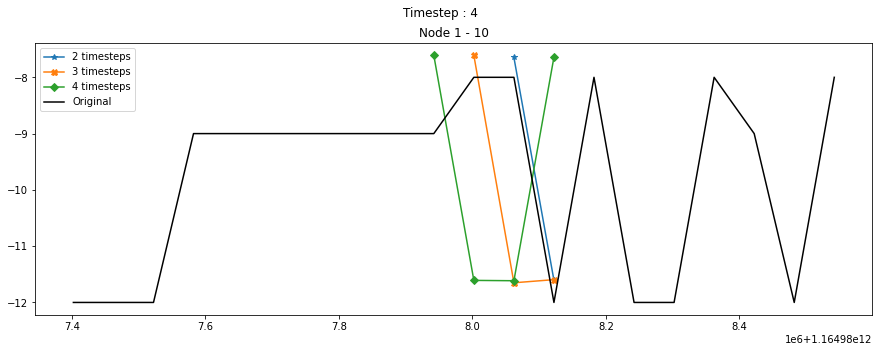

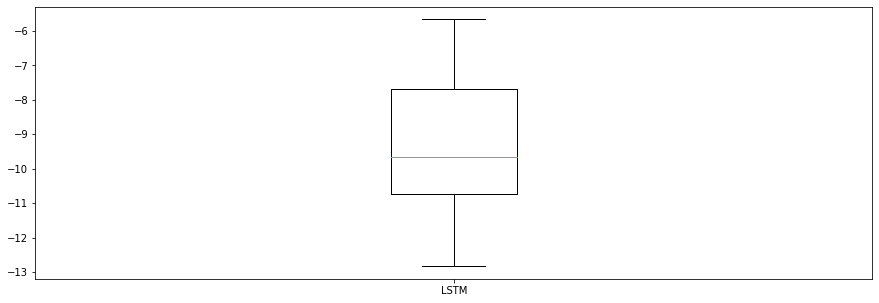

In [ ]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

# **Distribución Poisson**

* Para LQI
  *   media = 15
  
* Para RSSI
  * media = 210

No acumulado


----------------------- SIN DIFERENCIAS ---------------------


{'Errores modelo LSTM : 2': (344.33, 80.8419, 13.0611, -2.4308),
 'Errores modelo LSTM : 3': (364.0662,
  102.0509,
  14.0825,
  -4.9888202899216035e+31),
 'Errores modelo LSTM : 4': (333.7736, 79.4406, 13.1658, -2.3479)}

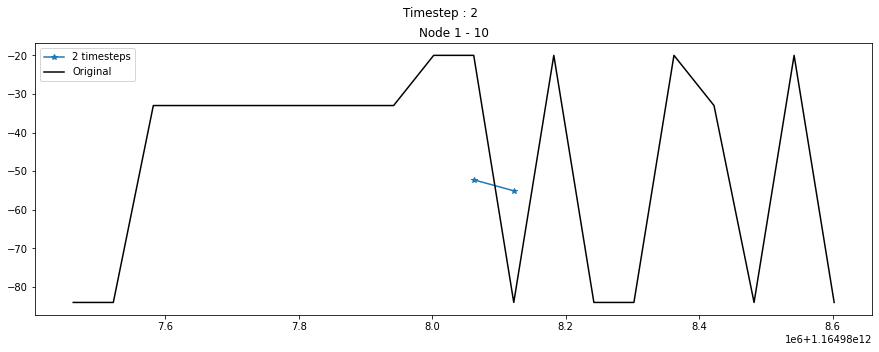

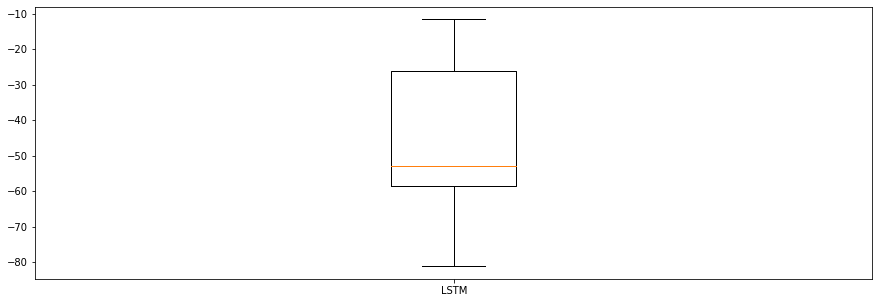

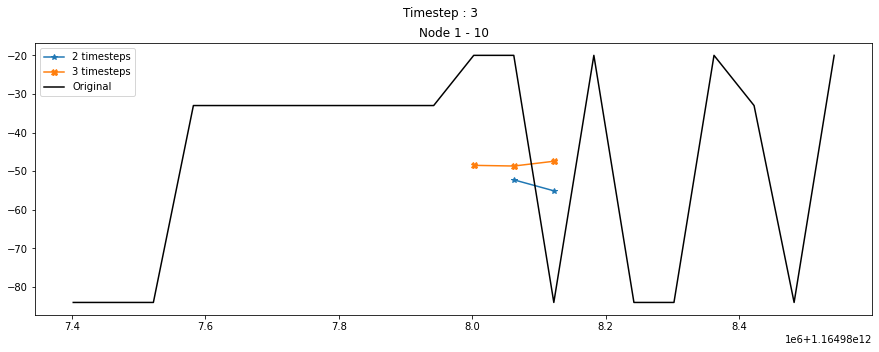

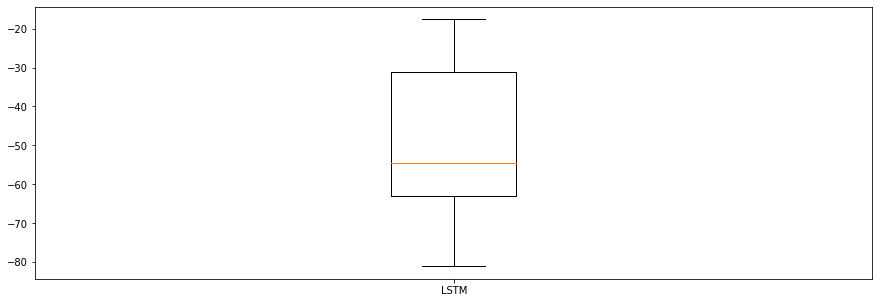

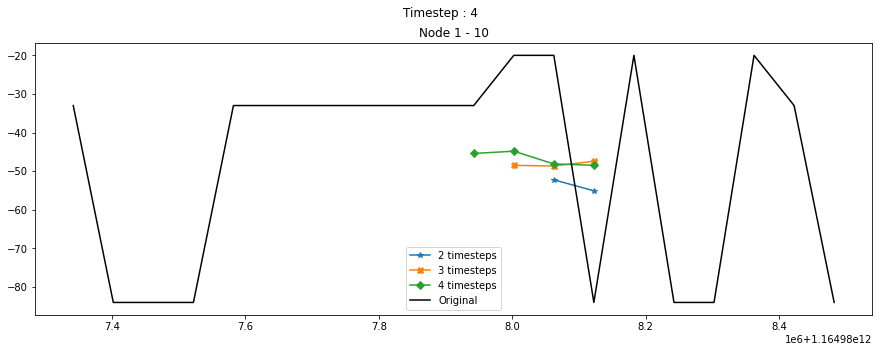

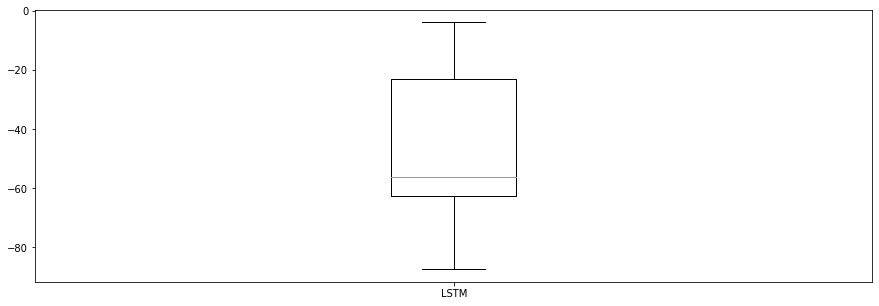

In [ ]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataPoisson.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 256
epocas = 16
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

-----------------------  SERIE DE DIFERENCIAS -----------------


{'Errores modelo LSTM : 2': (14.4214, 9.6461, 1.9575, 0.3042),
 'Errores modelo LSTM : 3': (46.0423, 17.0618, 2.0512, 0.3512),
 'Errores modelo LSTM : 4': (11.5478, 9.1429, 1.5771, 0.5819)}

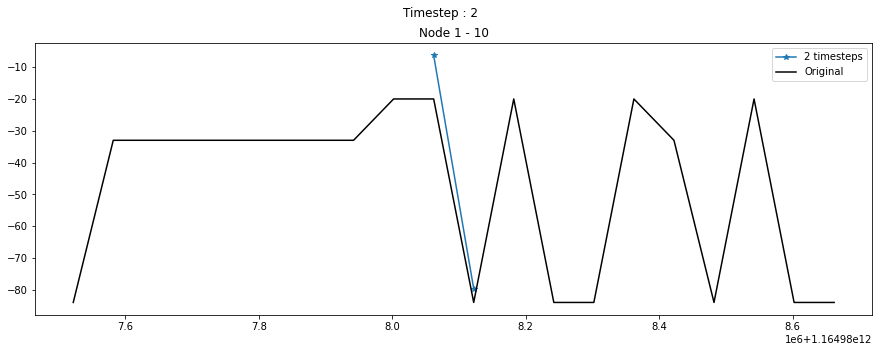

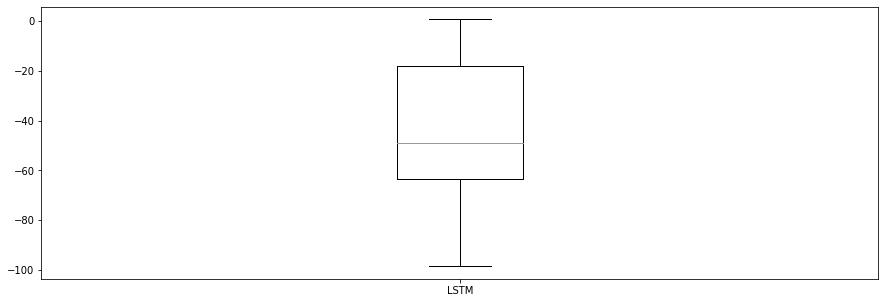

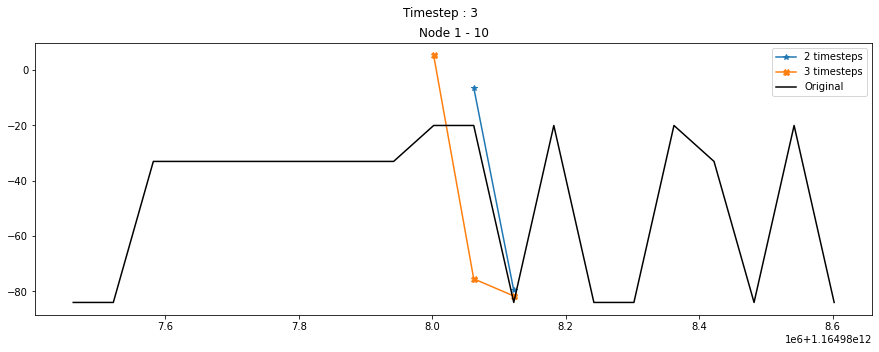

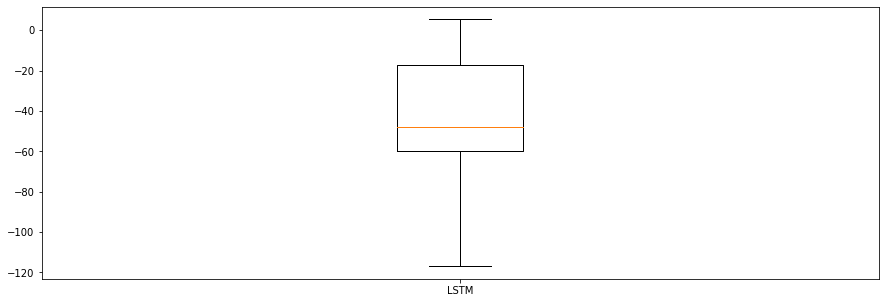

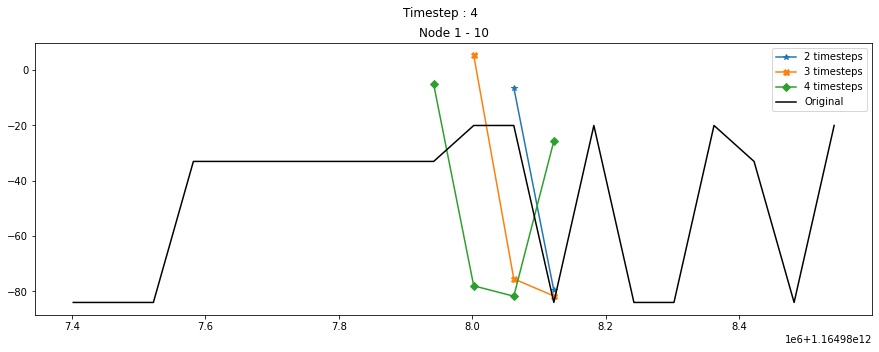

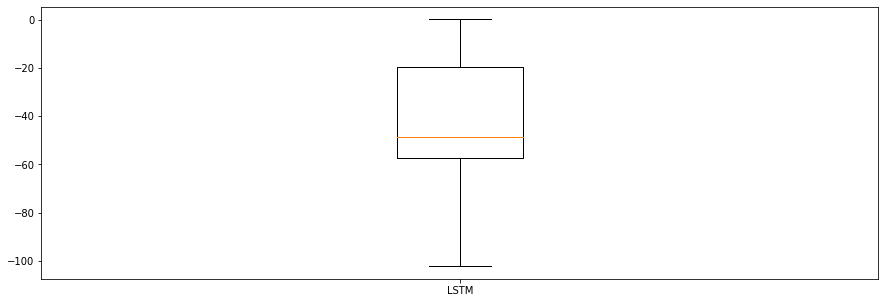

In [ ]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


{'Errores modelo LSTM : 2': (0.9627, 3.8507, 0.8326, 0.3522),
 'Errores modelo LSTM : 3': (1.5366, 4.8645, 1.0359, 0.5068),
 'Errores modelo LSTM : 4': (1.4647, 4.5903, 0.9797, 0.6243)}

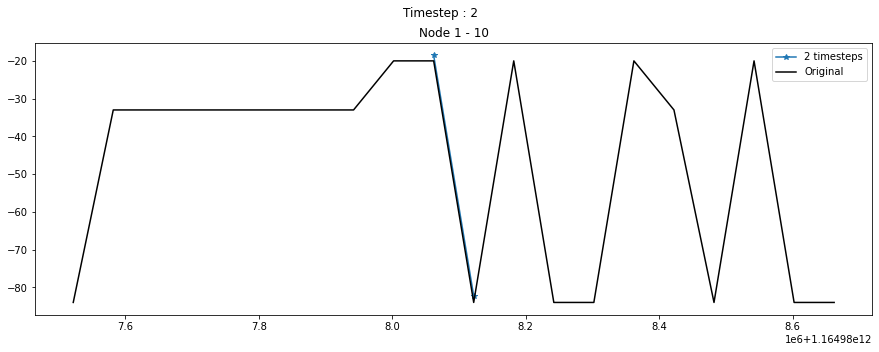

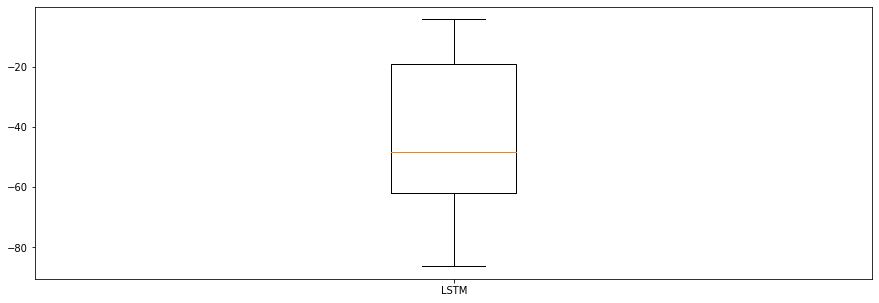

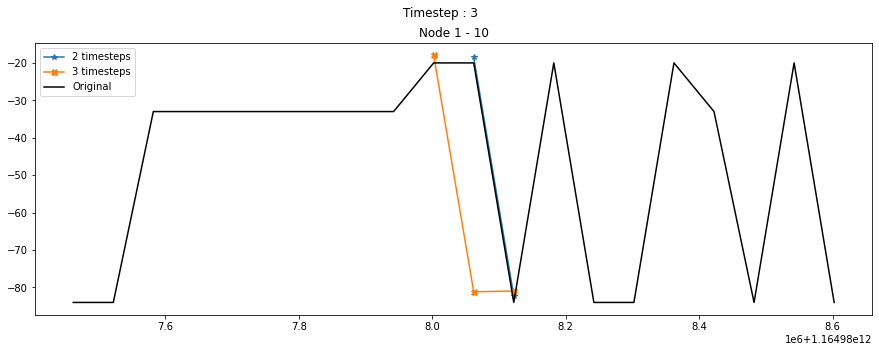

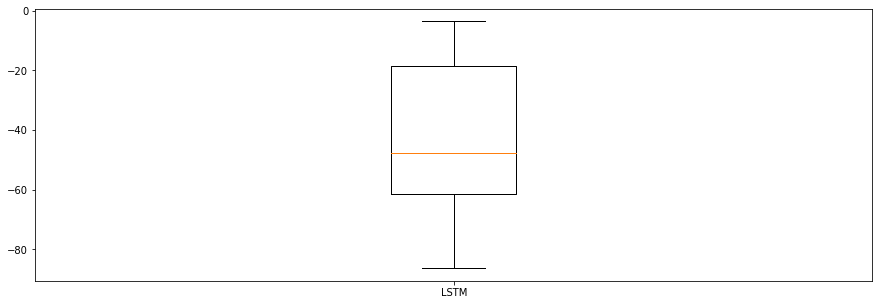

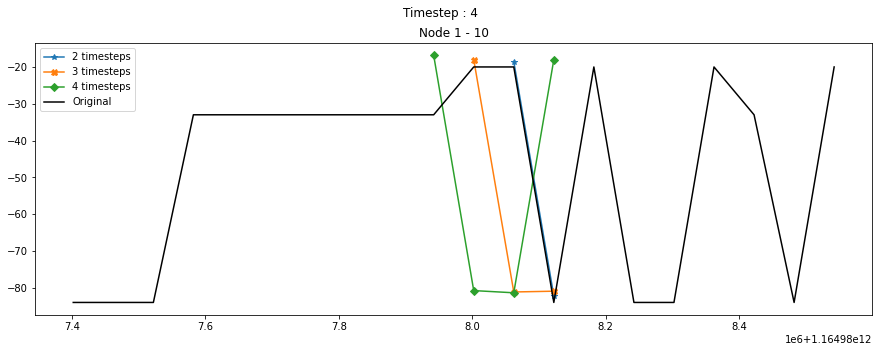

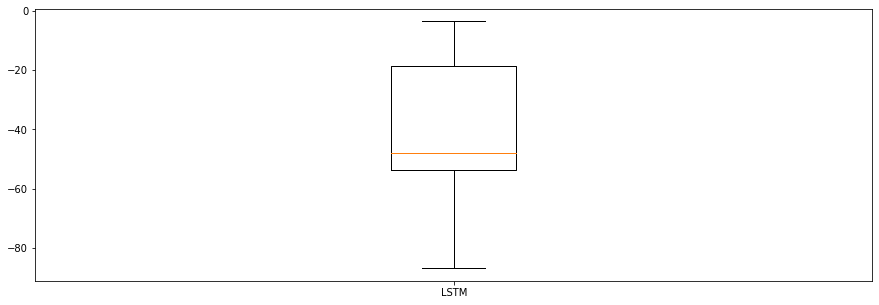

In [ ]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

# **Distribución Gamma**
* Para LQI
  alfa = 10
  beta = 3

* Para RSSI
  alfa = 10
  beta = 15

No acumulado

----------------------- SIN DIFERENCIAS ---------------------


{'Errores modelo LSTM : 2': (44.759, 614.0374, 6.6504, -15.4621),
 'Errores modelo LSTM : 3': (60.2996, 715.2197, 7.8651, -37.8941),
 'Errores modelo LSTM : 4': (50.8617, 647.8837, 6.5269, -2.99638302001229e+31)}

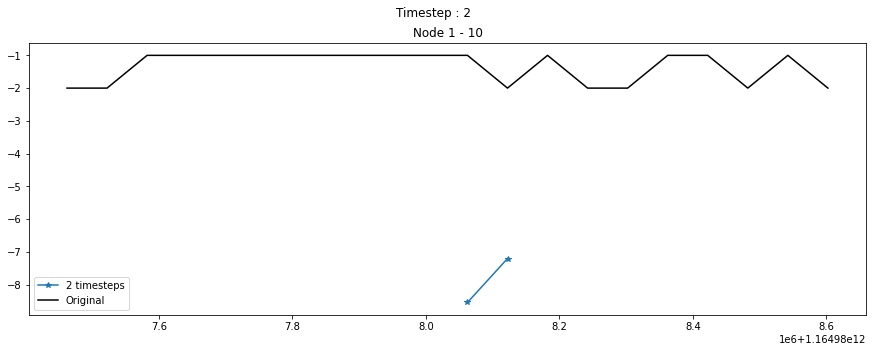

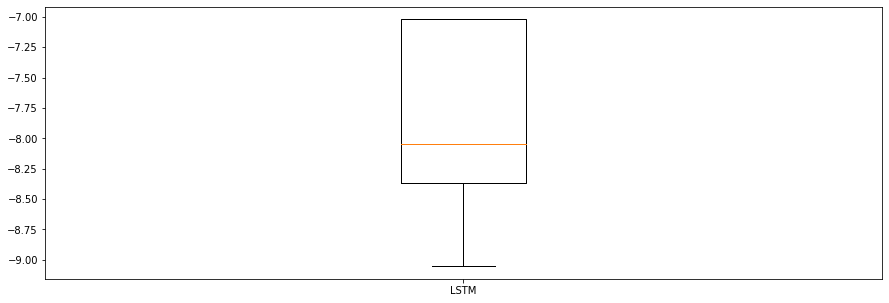

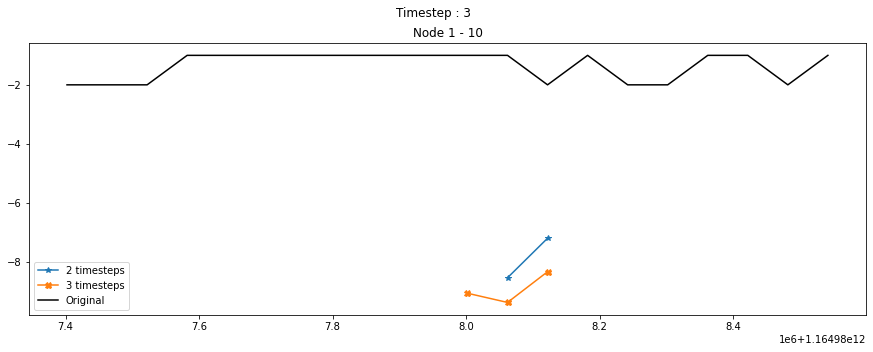

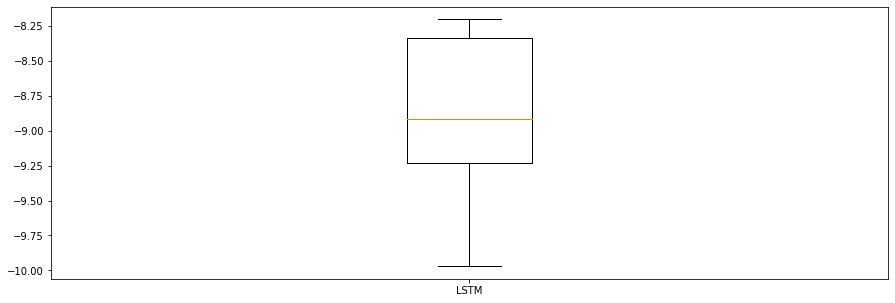

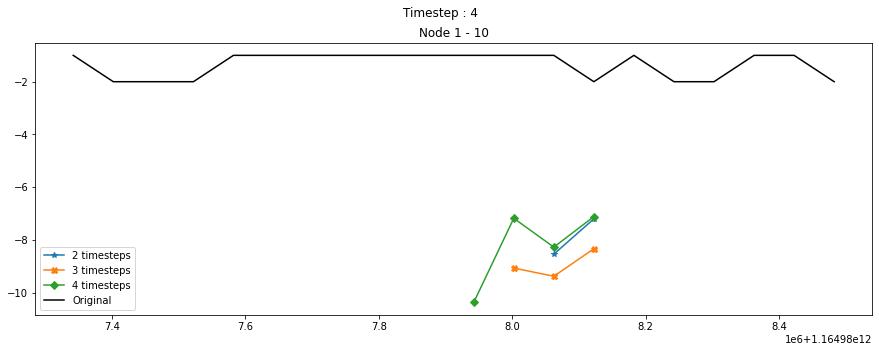

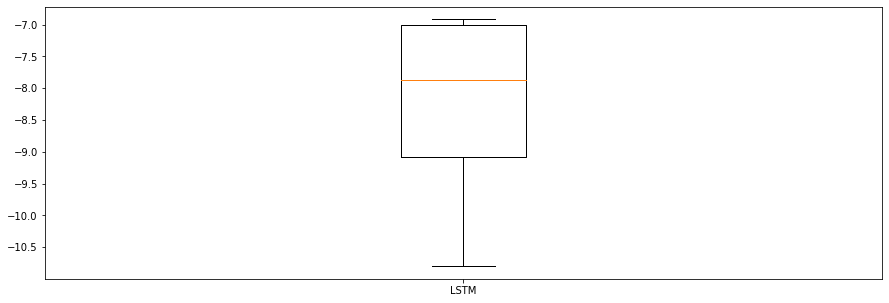

In [ ]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataGamma.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 256
epocas = 16
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

-----------------------  SERIE DE DIFERENCIAS -----------------


{'Errores modelo LSTM : 2': (0.147, 34.875, 0.3801, 0.0354),
 'Errores modelo LSTM : 3': (1.7484, 108.4852, 1.3063, -0.9764),
 'Errores modelo LSTM : 4': (2.4908, 135.4573, 1.2841, -1.8313)}

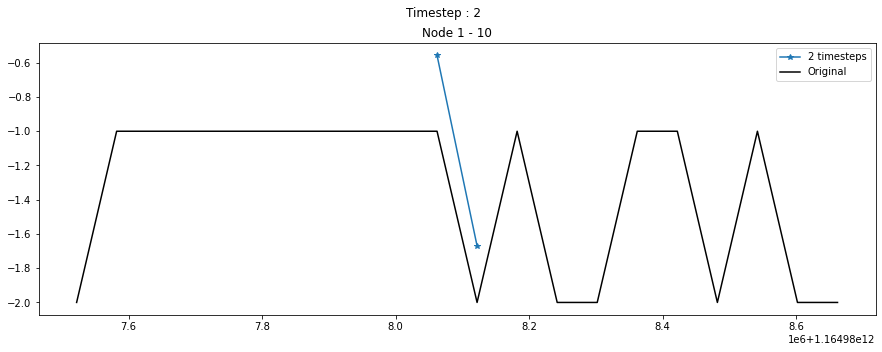

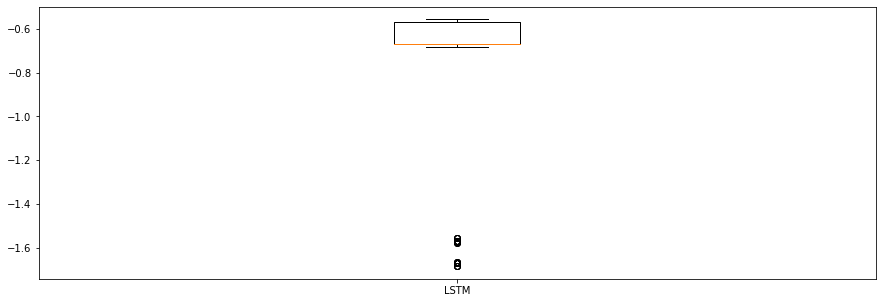

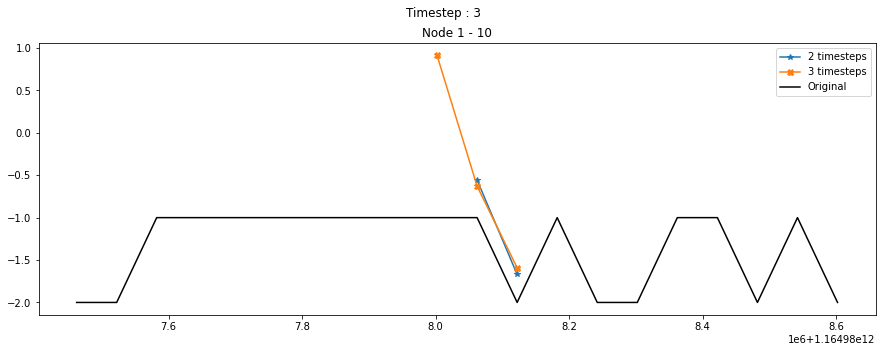

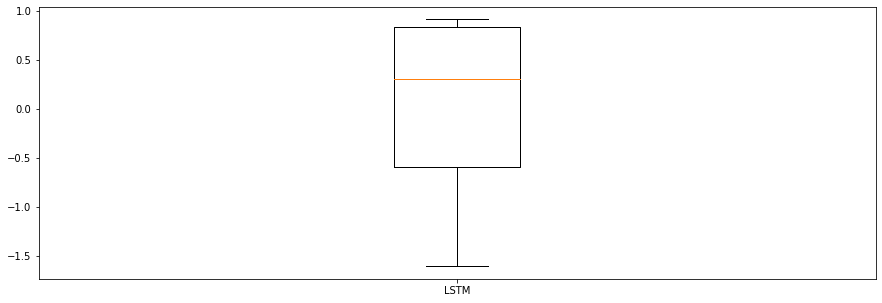

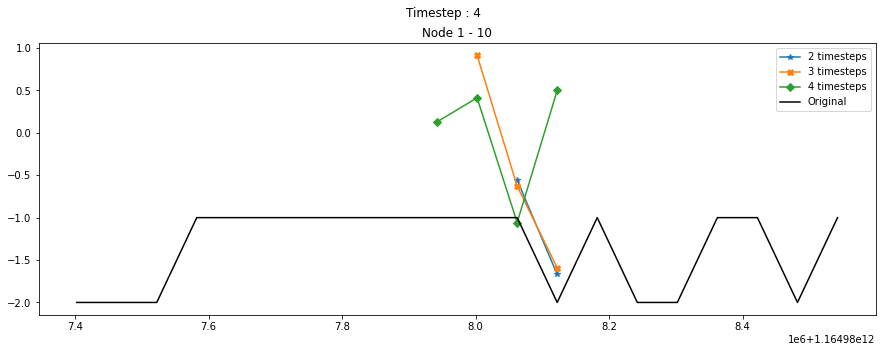

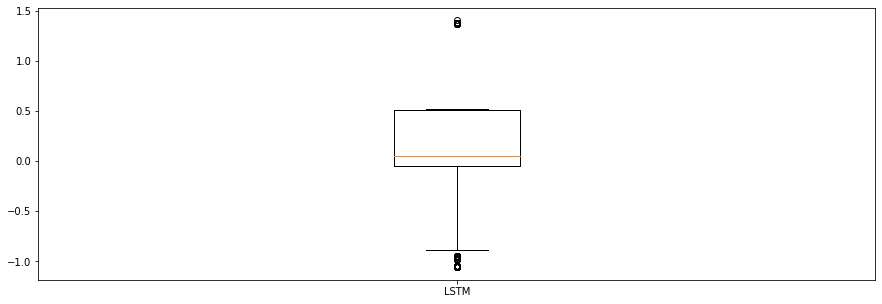

In [ ]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


{'Errores modelo LSTM : 2': (0.1115, 30.7848, 0.3288, 0.0617),
 'Errores modelo LSTM : 3': (0.3112, 51.3312, 0.5488, -0.0181),
 'Errores modelo LSTM : 4': (0.3311, 53.2341, 0.5796, -0.0452)}

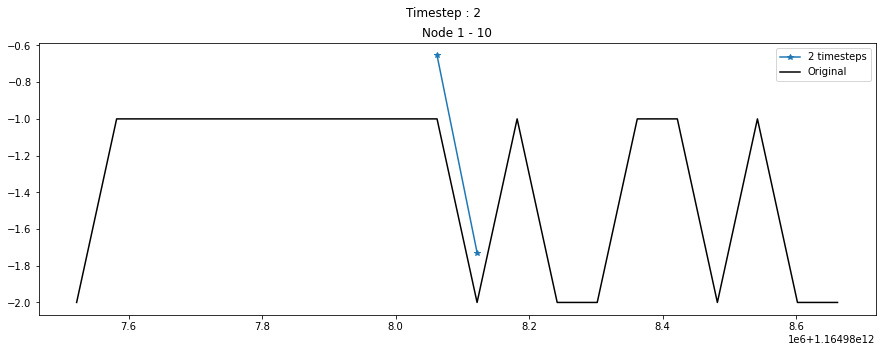

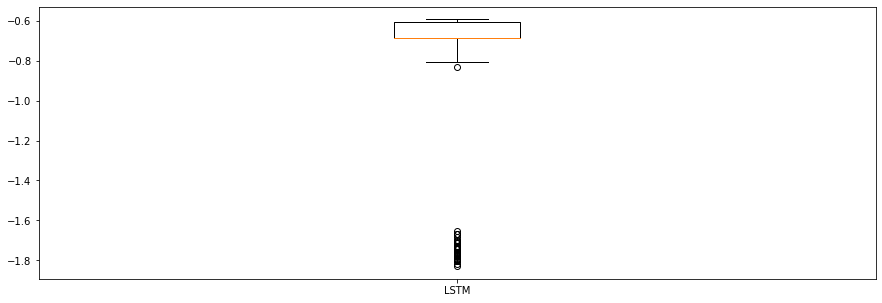

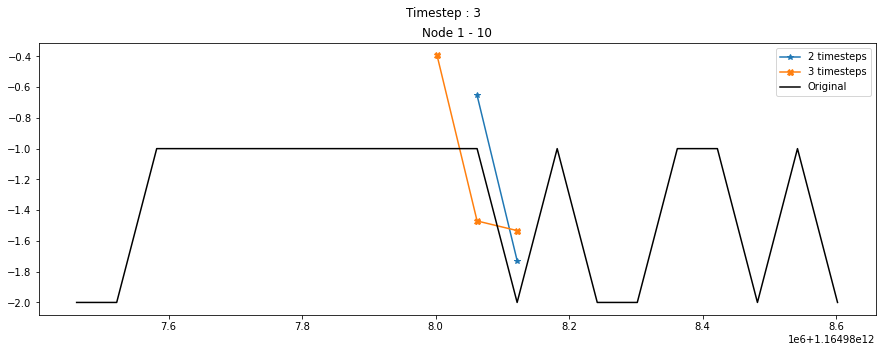

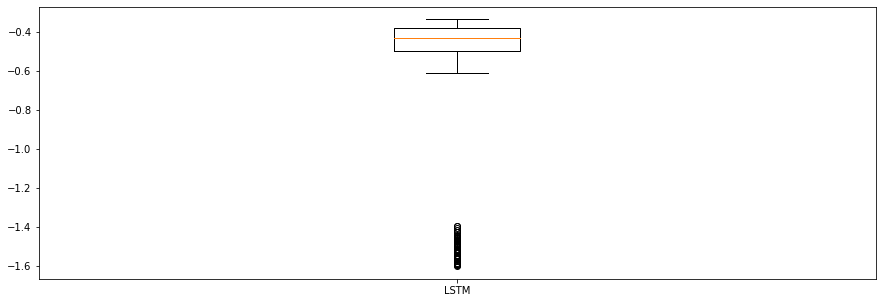

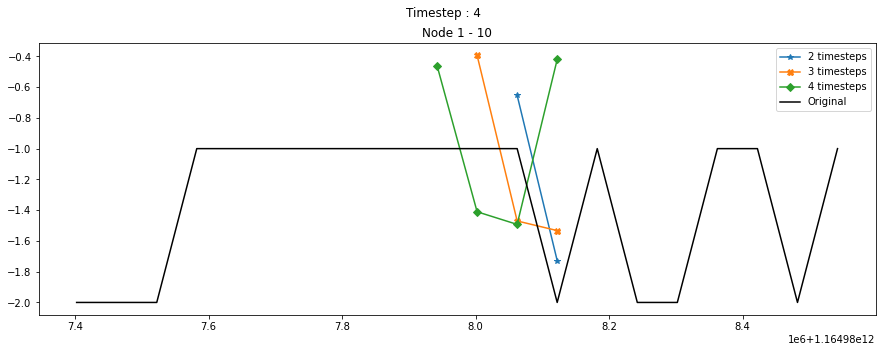

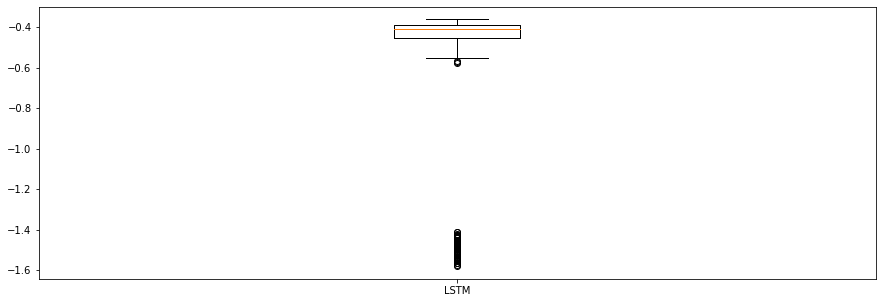

In [ ]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)